# Image Handling with PIL

## Imports

In [1]:
%matplotlib inline

from osgeo import osr, gdal

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import math

from PIL import Image, ImageDraw

from copy import deepcopy

sns.set(color_codes=True)

## Read Coconut Trees Location

In [2]:
banana_tree = pd.read_csv('../data/tree_bananas/locations.json', index_col=0)
banana_tree

,x,y
0,-175.338075,-21.087776
1,-175.338097,-21.087804
2,-175.338114,-21.087792
3,-175.338098,-21.087766
4,-175.338123,-21.087750
5,-175.338150,-21.087741
6,-175.338186,-21.087739
7,-175.338535,-21.087117
8,-175.338560,-21.087183
9,-175.338566,-21.087144


## Read Modified file

In [3]:
datafile = gdal.Open("../data/aerial_image/kolovai_lat_lon.tif")
bnd1 = datafile.GetRasterBand(1).ReadAsArray()
bnd2 = datafile.GetRasterBand(2).ReadAsArray()
bnd3 = datafile.GetRasterBand(3).ReadAsArray()
nx = datafile.RasterXSize # Raster xsize
ny = datafile.RasterYSize # Raster ysize

img = np.dstack((bnd1, bnd2, bnd3))
img = Image.fromarray(img)
print(img.size)

(18579, 24404)


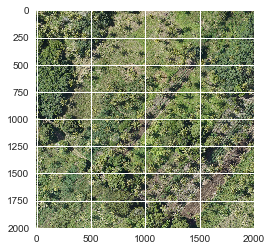

In [4]:
plt.imshow(np.asarray(img.crop((0,0,2000,2000))))

## Process and Chunk

### Coordinate Converter

In [5]:
class Converter:
    def __init__(self, gt):
        self.gt = gt
    
    def geo_2_pixel(self, x, y):
        pixel_x = (x - self.gt[0])/(self.gt[1])

        pixel_y = (y - self.gt[3])/(self.gt[5])
        
        return int(pixel_x), int(pixel_y)

### Slice original image

In [ ]:
img_w, img_h = img.size

slice_x = 1000
slice_y = 1000

Image.MAX_IMAGE_PIXELS = None

max_y = int(math.ceil(img_h/slice_y))
max_x = int(math.ceil(img_w/slice_x))


for y_start in range(0, max_y):
    for x_start in range(0, max_x):
        left = slice_x * x_start
        upper = slice_y * y_start
        bbox = (left, upper, left+slice_x, upper+slice_y)
        working_slice = img.crop(bbox)
        
        working_slice.save("../data/aerial_image/slices/slice__x_"+str(left)+"-"+str(left+slice_x)+"__y_"+ \
                           str(upper)+"-"+str(upper+slice_y)+".png")

### Mark trees on copy of image

In [6]:
loc_converter = Converter(datafile.GetGeoTransform())

marked_img = deepcopy(img)

draw_zone = ImageDraw.Draw(marked_img)

r = 5

for index, row in banana_tree.iterrows():
    x, y = loc_converter.geo_2_pixel(row['x'], row['y'])
    draw_zone.ellipse((x-r, y-r, x+r, y+r), fill=(0,0,255,255))

### Slice marked image

In [ ]:
img_w, img_h = marked_img.size

slice_x = 1000
slice_y = 1000

Image.MAX_IMAGE_PIXELS = None

max_y = int(math.ceil(img_h/slice_y))
max_x = int(math.ceil(img_w/slice_x))


for y_start in range(0, max_y):
    for x_start in range(0, max_x):
        left = slice_x * x_start
        upper = slice_y * y_start
        bbox = (left, upper, left+slice_x, upper+slice_y)
        working_slice = marked_img.crop(bbox)
        
        working_slice.save("../data/aerial_image/slices/marked__x_"+str(left)+"-"+str(left+slice_x)+"__y_"+ \
                           str(upper)+"-"+str(upper+slice_y)+".png")

# Don't Run

In [9]:
'''Image.MAX_IMAGE_PIXELS = None

crp = (3000, 13000, 4000, 14000)

working_slice = marked_img.crop(crp)
working_slice.show()
'''